In [1]:
import torch
import gzip
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("..")
from functions.sam_functions import batch_sample_from_class, show_points

In [4]:
embeddings = torch.load(
    "/Users/lisa/Documents/Master/sam-lab/ACDC/database/embeddings/embeddings.pt"
)

In [5]:
embeddings.shape

torch.Size([2978, 256, 64, 64])

# batched prompts

In [2]:
ground_truth_path = (
    "/Users/lisa/Documents/Master/sam-lab/ACDC/database/preprocess/ground_truth.npy.gz"
)
with gzip.open(ground_truth_path, "rb") as f:
    # Load the NumPy array from the file
    ground_truths = np.load(f)

In [3]:
ground_truth = ground_truths[0]
ground_truth = torch.tensor(ground_truth)
prompts = batch_sample_from_class(2, ground_truth, 1, 15, 5)

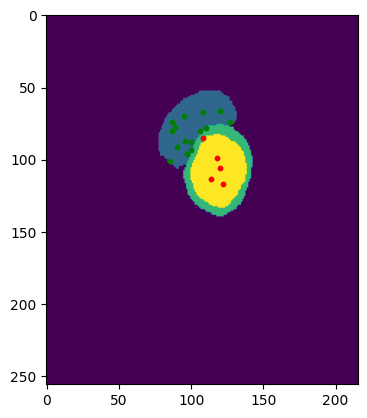

In [4]:
points, labels = prompts[0]
plt.imshow(ground_truth)
show_points(points, labels, ax=plt.gca())